In [1]:
# needed to import dataset from google drive into colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
cd gdrive

/content/gdrive


In [3]:
!ls

MyDrive


In [4]:
cd MyDrive

/content/gdrive/MyDrive


In [5]:
# Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.applications import ResNet50

In [6]:
# Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 100

In [7]:
!ls

 071795ba58e2cd600395cf8ecdaf10d1.jpg
 20241109_073815.jpg
'20241209_071907 (1).mp4'
 21121A0555-WEB
 7792adb9-4198-46ba-8a39-8390b334911d.pdf
'9. Implement a program for Features Identification in Fingerprint Recognition System and 10. Implement a program using Texture based Image Classification, find the accuracy level using Receiver Operating curve..ipynb'
 a74b30a7-6f2e-46b1-b3a6-d73d1ee23460.jpg
 cancer_dataset
 cancer-full-dataset-20241108T162204Z-001.zip
 certificates
 Classroom
'Colab Notebooks'
'Copy of passport_size_photo.jpg'
'Copy of *Your Name * - Product Analyst Assignment.gdoc'
 cv
 datasets
 deltax1.pdf
 deltax2.pdf
 deltax.pdf
'Django projects gc'
'DURGAM LOKANANDAM - Product Analyst Assignment.pdf'
'finaly report.pdf'
 image1.jpg
 image.jpg
'Interview Topics.odt'
 ML
 PHOTO.jpg
 Placements
'Resume1 (1).pdf'
'Resume (1).gdoc'
 Resume1.pdf
 Resume3.pdf
 Resumebc.pdf
 Resume.gdoc
 resume.pdf
 Resume.pdf
 Screenshot_20230908_192440_Chrome.jpg
 Screenshot_20230908_194416_P

In [8]:
!unzip -o '/content/gdrive/MyDrive/cancer-full-dataset-20241108T162204Z-001.zip' -d datasets


Archive:  /content/gdrive/MyDrive/cancer-full-dataset-20241108T162204Z-001.zip
  inflating: datasets/cancer-full-dataset/benign/bs (9).png  
  inflating: datasets/cancer-full-dataset/benign/bs (25).png  
  inflating: datasets/cancer-full-dataset/benign/bs (30).png  
  inflating: datasets/cancer-full-dataset/benign/bs (3).png  
  inflating: datasets/cancer-full-dataset/benign/bs (27).png  
  inflating: datasets/cancer-full-dataset/benign/bs (489).png  
  inflating: datasets/cancer-full-dataset/benign/bs (2).png  
  inflating: datasets/cancer-full-dataset/benign/bs (23).png  
  inflating: datasets/cancer-full-dataset/benign/bs (10).png  
  inflating: datasets/cancer-full-dataset/benign/bs (13).png  
  inflating: datasets/cancer-full-dataset/benign/bs (31).png  
  inflating: datasets/cancer-full-dataset/benign/bs (5).png  
  inflating: datasets/cancer-full-dataset/benign/bs (32).png  
  inflating: datasets/cancer-full-dataset/benign/bs (11).png  
  inflating: datasets/cancer-full-dataset/

In [9]:
# Import dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets/cancer-full-dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
class_names

Found 1968 files belonging to 2 classes.


['benign', 'malignant']

In [10]:
# Function to Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# Building the Model
# Creating a new Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])


In [14]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])


In [15]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers

# Constants
IMAGE_SIZE = 224
CHANNELS = 3
n_classes = 2

# Base model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
base_model.trainable = False  # Freeze the ResNet50 layers

# Model Architecture
model = models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(n_classes, activation='softmax')
])

# Print model summary to verify
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [25]:
# Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 945ms/step - accuracy: 0.6932 - loss: 0.6448 - val_accuracy: 0.8011 - val_loss: 0.5233
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.7855 - loss: 0.4886 - val_accuracy: 0.7841 - val_loss: 0.5064
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step - accuracy: 0.8093 - loss: 0.4402 - val_accuracy: 0.7898 - val_loss: 0.4653
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 332ms/step - accuracy: 0.8078 - loss: 0.4199 - val_accuracy: 0.8295 - val_loss: 0.4148
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.8117 - loss: 0.4123 - val_accuracy: 0.8182 - val_loss: 0.4191
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.8222 - loss: 0.3975 - val_accuracy: 0.8523 - val_loss: 0.4046
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.8443 - loss: 0.3684 - val_accuracy: 0.8466 - val_loss: 0.3893
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.8232 - loss: 0.3649 - 

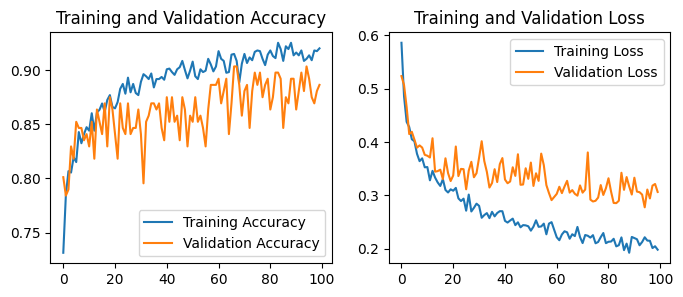

In [27]:
# Plotting the Accuracy and Loss Curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 49}

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


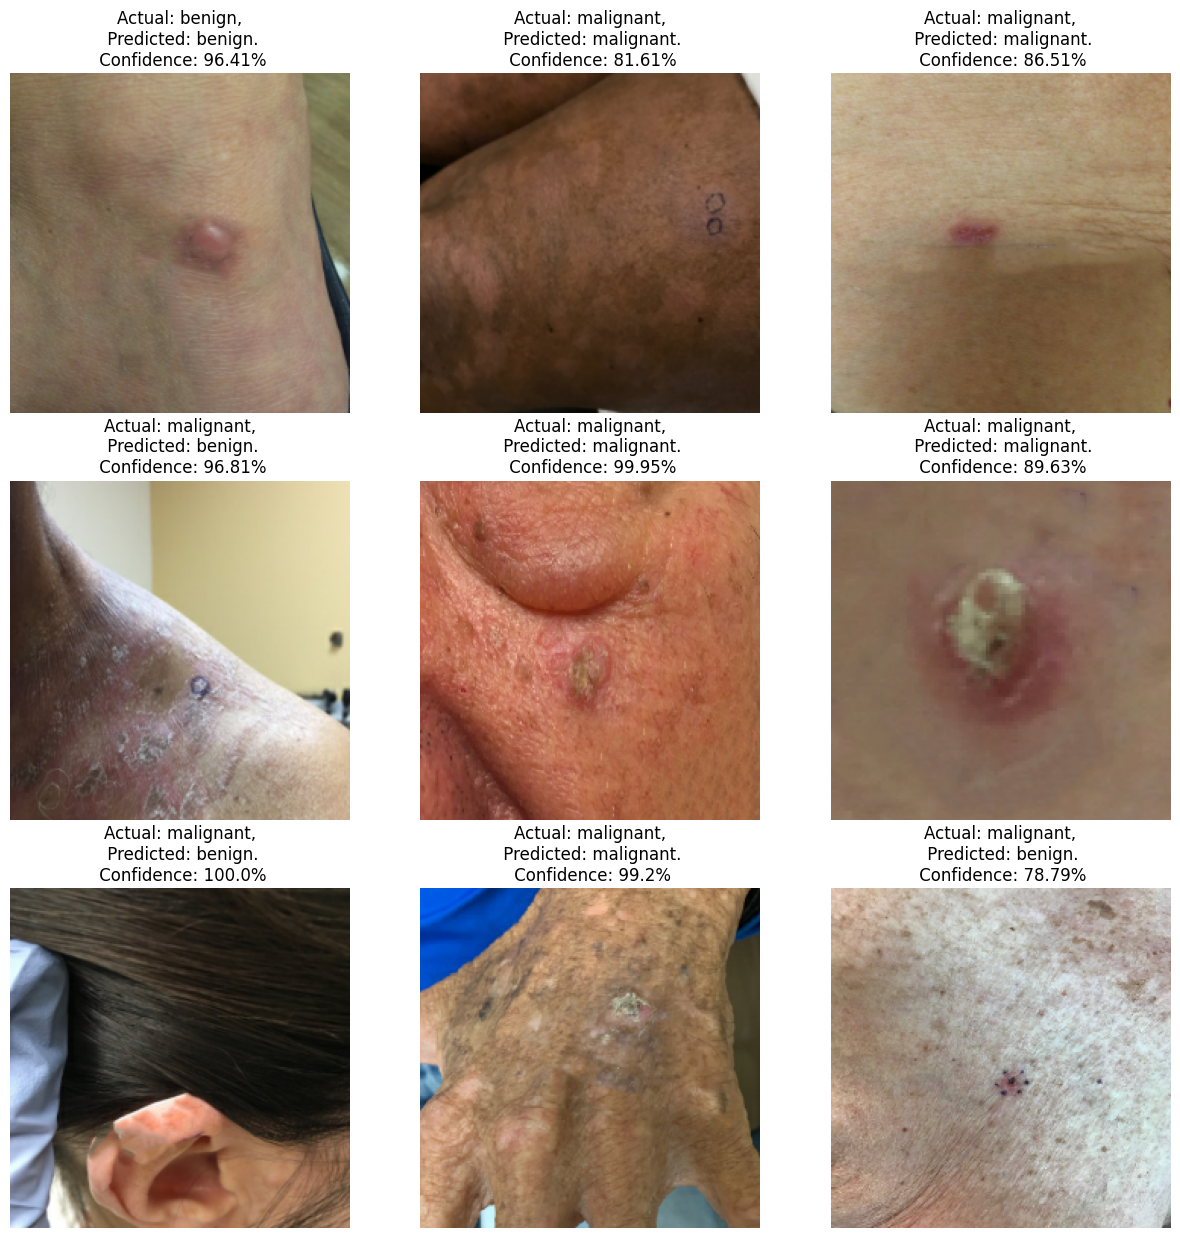

In [29]:
# Run prediction on a sample image
def predict(model, img):
    img_array = tf.expand_dims(img, 0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [30]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9026 - loss: 0.2670
Test Loss: 0.274168998003006
Test Accuracy: 0.8883928656578064


In [31]:
scores = model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8983 - loss: 0.2736


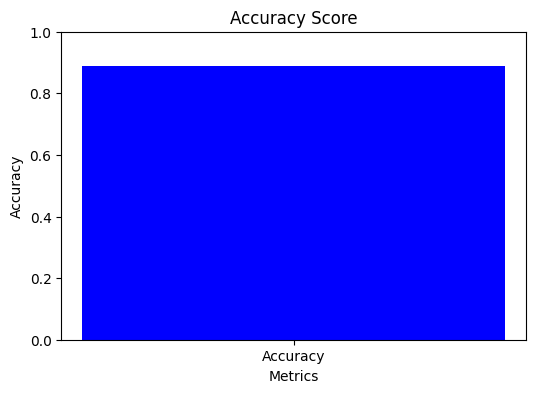

In [32]:

# Plotting the Accuracy Score
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [scores[1]], color='blue')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.xlabel("Metrics")
plt.ylabel("Accuracy")
plt.title("Accuracy Score")
plt.show()


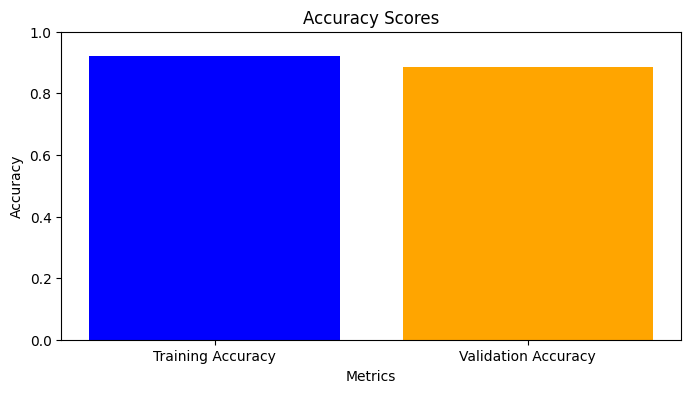

In [33]:
# Plotting the Training Accuracy Score and Validation Accuracy Score
plt.figure(figsize=(8, 4))
metrics = ["Training Accuracy", "Validation Accuracy"]
accuracy_scores = [acc[-1], val_acc[-1]]

plt.bar(metrics, accuracy_scores, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.xlabel("Metrics")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


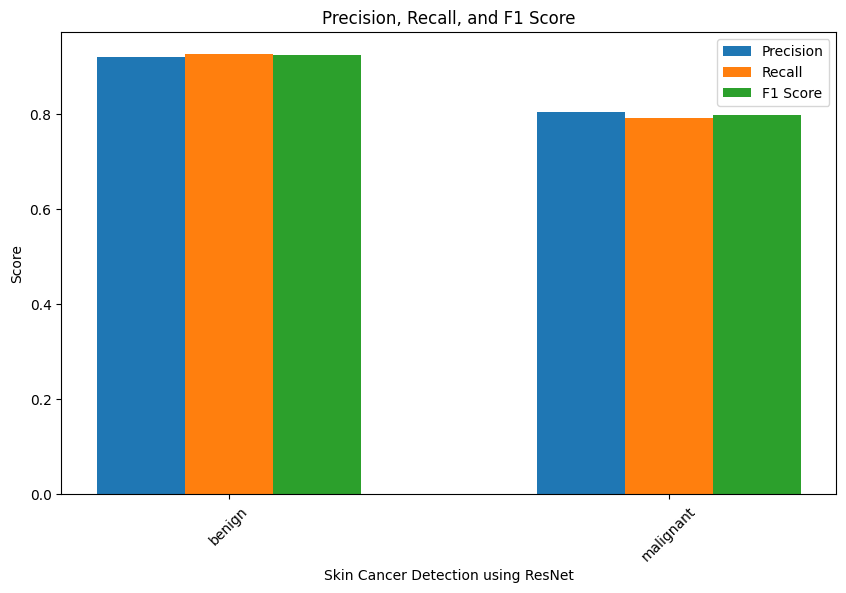

In [34]:

# Printing Precision, Recall, and F1 Score
test_images = []
test_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))

test_labels = np.array(test_labels)
predicted_labels = np.array(predicted_labels)

precision = precision_score(test_labels, predicted_labels, average=None)
recall = recall_score(test_labels, predicted_labels, average=None)
f1 = f1_score(test_labels, predicted_labels, average=None)

# Plotting the metrics
plt.figure(figsize=(10, 6))
x = np.arange(len(class_names))

plt.bar(x - 0.2, precision, width=0.2, label='Precision')
plt.bar(x, recall, width=0.2, label='Recall')
plt.bar(x + 0.2, f1, width=0.2, label='F1 Score')

plt.xticks(x, class_names, rotation=45)
plt.xlabel('Skin Cancer Detection using ResNet')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


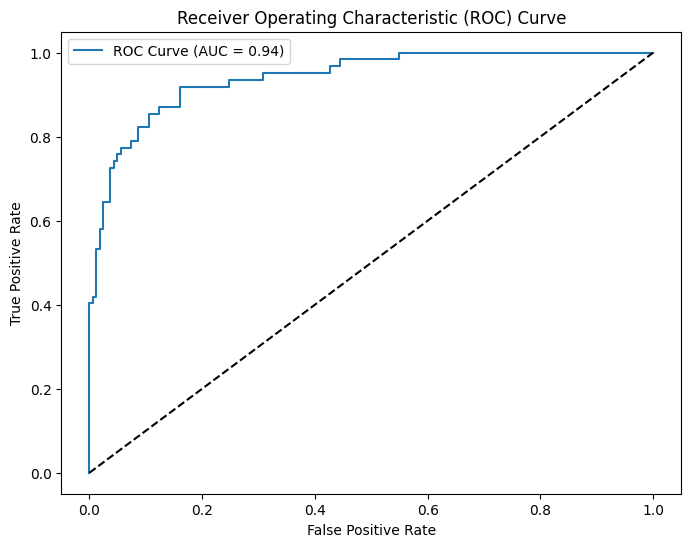

AUC Score: 0.9416567104739147


In [35]:
# After evaluating the model on the test set
test_labels = []
predicted_probabilities = []

for images_batch, labels_batch in test_ds:
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_probabilities.extend(batch_prediction)

test_labels = np.array(test_labels)
predicted_probabilities = np.array(predicted_probabilities)

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_labels, predicted_probabilities[:, 1])
auc_score = roc_auc_score(test_labels, predicted_probabilities[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print the AUC score
print('AUC Score:', auc_score)


In [36]:
# Saving the Model
model.save("RestNet.h5")

In [37]:
import os
print(os.path.exists("RestNet.h5"))


True


In [41]:
!ls /content/gdrive/MyDrive/


 071795ba58e2cd600395cf8ecdaf10d1.jpg
 20241109_073815.jpg
'20241209_071907 (1).mp4'
 21121A0555-WEB
 7792adb9-4198-46ba-8a39-8390b334911d.pdf
'9. Implement a program for Features Identification in Fingerprint Recognition System and 10. Implement a program using Texture based Image Classification, find the accuracy level using Receiver Operating curve..ipynb'
 a74b30a7-6f2e-46b1-b3a6-d73d1ee23460.jpg
 cancer_dataset
 cancer-full-dataset-20241108T162204Z-001.zip
 certificates
 Classroom
'Colab Notebooks'
'Copy of passport_size_photo.jpg'
'Copy of *Your Name * - Product Analyst Assignment.gdoc'
 cv
 datasets
 deltax1.pdf
 deltax2.pdf
 deltax.pdf
'Django projects gc'
'DURGAM LOKANANDAM - Product Analyst Assignment.pdf'
'finaly report.pdf'
 image1.jpg
 image.jpg
'Interview Topics.odt'
 ML
 PHOTO.jpg
 Placements
 RestNet.h5
'Resume1 (1).pdf'
'Resume (1).gdoc'
 Resume1.pdf
 Resume3.pdf
 Resumebc.pdf
 Resume.gdoc
 resume.pdf
 Resume.pdf
 Screenshot_20230908_192440_Chrome.jpg
 Screenshot_20230